## Directory files parser

#### Bandai namco

In [2]:
import os

def listBvhFiles(path:str) -> list[str]:
    result = []
    for item in os.listdir(path):
        itemPath = os.path.join(path, item)
        if os.path.isdir(itemPath): result.extend(listBvhFiles(itemPath))
        elif item.endswith('.bvh'): result.append(itemPath)
    return result

# getting all files ins the repository extracting labels
dataSetPath = '.\\Bandai-Namco-Research-Motiondataset\\dataset'
fileList:list[tuple[str, list[str]]] = []

for item in listBvhFiles(dataSetPath):
    fileName = item.split('\\')[-1]
    labels = fileName.split('_')[:-1]
    fileList.append((item, labels))

print(f'Files: {len(fileList)}')
# for f in fileList: print(f)

Files: 3077


## Motion featue extraction

In [3]:
import bvhio
import numpy
import glm

file = fileList[163]; print(file[1])
root = bvhio.read(file[0])
root = root.filter('Hips')[0].clearParent()
root.Scale = glm.vec3(0.01)
root.Position *= root.Scale
root.printTree()

['dataset-1', 'walk', 'normal']
Hips
+- Spine
|  +- Chest
|     +- Neck
|     |  +- Head
|     +- Shoulder_L
|     |  +- UpperArm_L
|     |     +- LowerArm_L
|     |        +- Hand_L
|     +- Shoulder_R
|        +- UpperArm_R
|           +- LowerArm_R
|              +- Hand_R
+- UpperLeg_L
|  +- LowerLeg_L
|     +- Foot_L
|        +- Toes_L
+- UpperLeg_R
   +- LowerLeg_R
      +- Foot_R
         +- Toes_R


#### Extract local & world data & more features

In [57]:
animationData = []
layout = root.layout()
jointCount = len(layout)

for frame in range(len(root.Keyframes)):
    root.readPose(frame)
    rootWorldPosition = root.pointToWorld((0,0,0))

    frameData = []
    for joint, index, depth in layout:
        jointData = []

        jointData.append(joint.RightLocal)                                      # 00 X-dir local
        jointData.append(joint.UpLocal)                                         # 01 Y-dir local
        jointData.append(joint.ForwardLocal)                                    # 02 Z-dir local

        jointData.append(joint.RightWorld)                                      # 03 X-dir world
        jointData.append(joint.UpWorld)                                         # 04 Y-dir world
        jointData.append(joint.ForwardWorld)                                    # 05 Z-dir world

        jointData.append(joint.Position)                                        # 06 Pos local
        jointData.append(joint.pointToWorld((0,0,0)))                           # 07 Pos world
        jointData.append(rootWorldPosition - joint.pointToWorld((0,0,0)))       # 08 Pos hips

        frameData.append(jointData)
    animationData.append(frameData)

# (frame, type, joint, XYZ)
animationData = numpy.array(animationData)
animationData = numpy.moveaxis(animationData, 2, 1)
print(f'{animationData.shape} - Animation')

averageData = numpy.array(animationData[:, :, :, :])
averageData = numpy.average(animationData, axis=2, keepdims=True)
averageData[:, :6] /= numpy.linalg.norm(averageData[:, :6], axis=-1, keepdims=True)
print(f'{averageData.shape} - Averages')

velocityData = numpy.array(animationData[:, 6:9, :, :])
velocityData = numpy.subtract(velocityData, numpy.roll(velocityData, -1, axis=0))
print(f'{velocityData.shape} - Velocities')

angularData = numpy.array(numpy.append(animationData, averageData, axis=2)[:, 0:6, :, :])
angularData = numpy.split(angularData, 3, axis=1) # split into 3x3 matrices
angularData = numpy.moveaxis(numpy.array(angularData), 0, 3) # combine lists
angularData = numpy.roll(angularData, -1, axis=0) * numpy.moveaxis(angularData, -1, -2) # D = AxB*
angularData = numpy.arccos((numpy.trace(angularData, axis1=-1, axis2=-2) - 1) / 2) # calc radians
print(f'{angularData.shape} - Angular') # http://www.boris-belousov.net/2016/12/01/quat-dist/

# calculate global energy

(195, 9, 21, 3) - Animation
(195, 9, 1, 3) - Averages
(195, 3, 21, 3) - Velocities
(195, 2, 22) - Angular


#### Plot data

In [66]:
import matplotlib.pyplot as plt

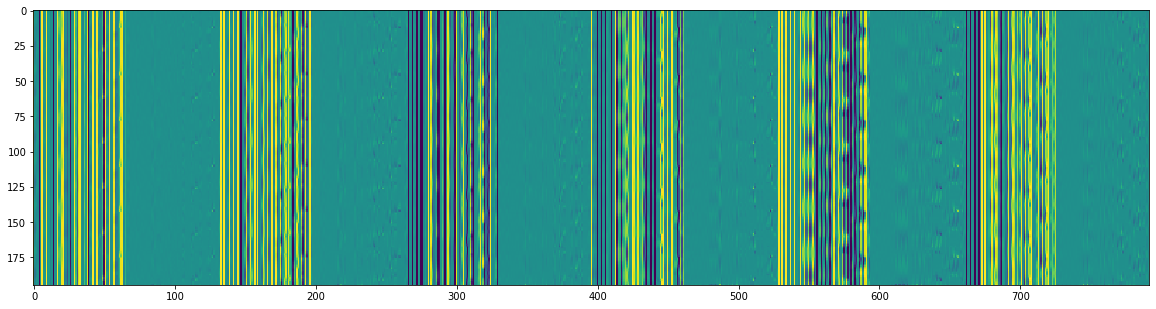

In [67]:
dirData = data[:, :6, :, :]
dirShape = (dirData.shape[0], numpy.prod(dirData.shape[1:]))
dirPicture = numpy.reshape(numpy.array(dirData), dirShape)

plt.figure(figsize = (20,20))
plt.imshow(dirPicture, interpolation='nearest')
pass

In [ ]:
dirData = data[:, :6, :, :]
dirShape = (dirData.shape[0], numpy.prod(dirData.shape[1:]))
dirPicture = numpy.reshape(numpy.array(dirData), dirShape)

plt.figure(figsize = (20,20))
plt.imshow(dirPicture, interpolation='nearest')
pass